## Importing Libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [40]:
# List of filenames containing our FOREX data
forex_tables_glob = glob("../data/*.xls")

def create_forex_df(all_files_glob=glob("../data/*.xls")):

    all_files = all_files_glob

    li = []

    for filename in all_files:
        tdf = pd.read_excel(filename, skiprows=5, na_values=['CLOSED', 'closed', 'Closed', ' --']).drop([0,1,2,3,4])
        tdf = tdf.rename(columns={'Units':'Date'})

        # Convert Date to Datetime type
        tdf['Date'] = pd.to_datetime(tdf['Date'])

        # Create time series index
        tdf = tdf.set_index('Date', drop=True)
        li.append(tdf)

    df = pd.concat(li, axis=0, sort=False)
    
    return df

data = create_forex_df(forex_tables_glob).astype('float')

## Train, Validation, Test Split

Train Data : 2017 to 2018\
Validation Data : 2019\
Test Data : Jan 2020 to Feb 2020

In [18]:
# Data after 2017 (past 3 years)
data_3yrs = data['2017':]
df = data_3yrs[['USD']]

print("Total data count = ", df.shape[0])
print("Number of missing values = ", df.isnull().sum().sum())
print()

for i in range(1, 11):
    label = "lag_{}".format(i)
    df[label] = df['USD'].shift(i)
    
df = df.dropna(axis=0)

train_df = df['2017':'2018']
val_df = df['2019']
test_df = df['2020']

print("Count of dates in training data = ", train_df.shape[0])
print("Count of dates in validation data = ", val_df.shape[0])
print("Count of dates in test data = ", test_df.shape[0])

Total data count =  778
Number of missing values =  0

Count of dates in training data =  491
Count of dates in validation data =  251
Count of dates in test data =  26


# Data Exploration

#### Print datatypes

In [19]:
print("Datatypes of the dataset -\n")
print("Train : ", train_df.dtypes.unique())
print("Test : ", test_df.dtypes.unique())
print("Validation : ", val_df.dtypes.unique())

Datatypes of the dataset -

Train :  [dtype('float64')]
Test :  [dtype('float64')]
Validation :  [dtype('float64')]


#### Plot AUD/USD

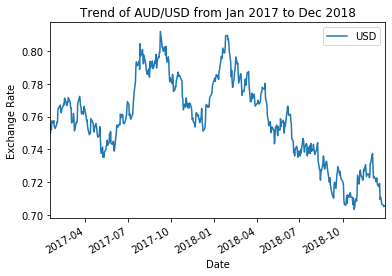

In [20]:
train_rate = train_df[['USD']]
train_rate.plot()
plt.ylabel("Exchange Rate")
plt.title("Trend of AUD/USD from Jan 2017 to Dec 2018")
plt.show()

#### Which days, weeks, months, years have the highest/lowest rates on average? (1983 - 2019)

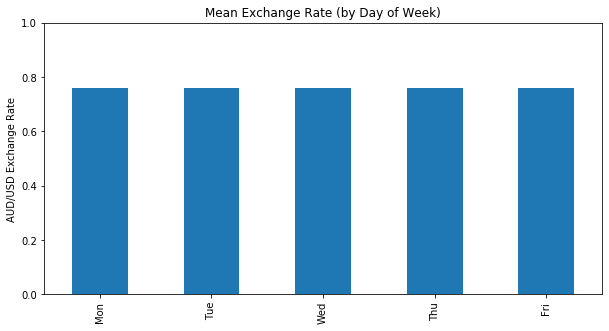

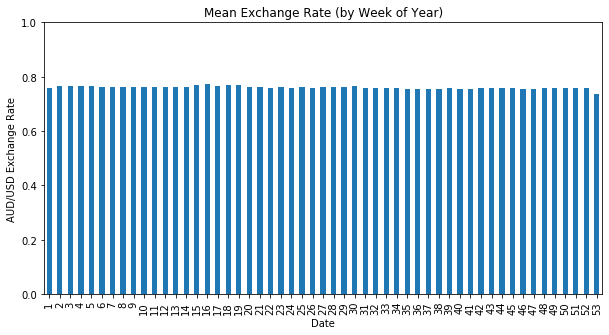

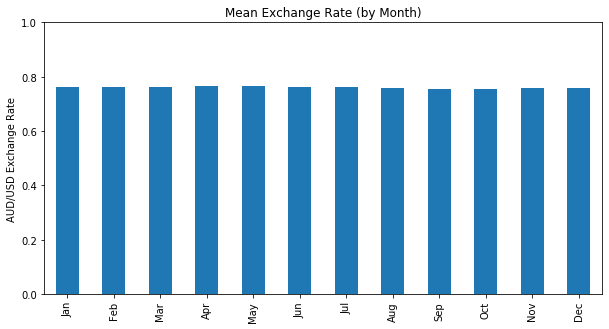

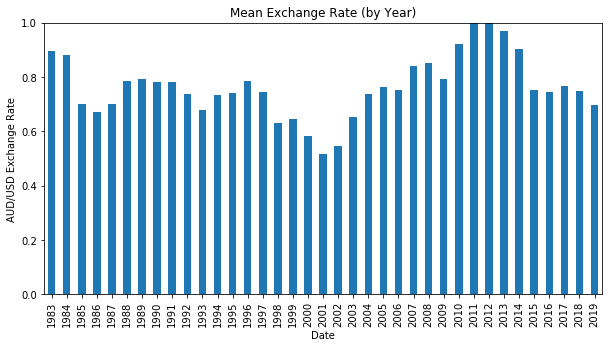

In [21]:
rate_1983_2019 = data[['USD']][:'2019']

def mean_exchange_rate(rate, year_=False):
    days = rate.index.dayofweek
    weeks = rate.index.week
    months = rate.index.month
    
    period = [days, weeks, months]
    titles = ['Day of Week', 'Week of Year', 'Month']
    
    if year_:
        year = rate.index.year
        period.append(year)
        titles.append('Year')

    for period, label in zip(period, titles):

        sub = rate.groupby(period).agg(np.mean).dropna()

        if (period == days).all():
            sub.index = ["Mon", 'Tue', 'Wed', 'Thu', 'Fri']
        elif (period == months).all():
            sub.index = ["Jan", 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

        sub.plot(kind='bar',
                 title='Mean Exchange Rate (by {})'.format(label),
                 figsize=(10,5),
                 legend = False)
        plt.ylabel("AUD/USD Exchange Rate")
        plt.ylim(0,1)
        plt.show()
        
mean_exchange_rate(rate_1983_2019, year_=True)

#### Which days, weeks, months have the highest/lowest rates on average? (2017 to 2019)

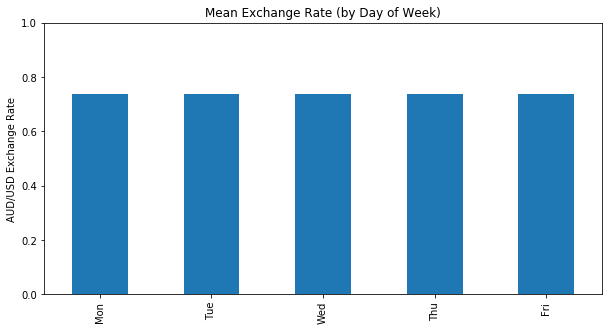

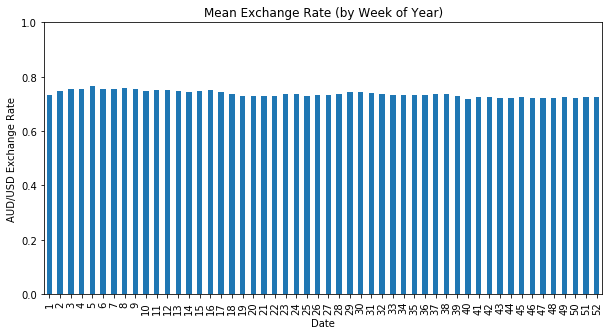

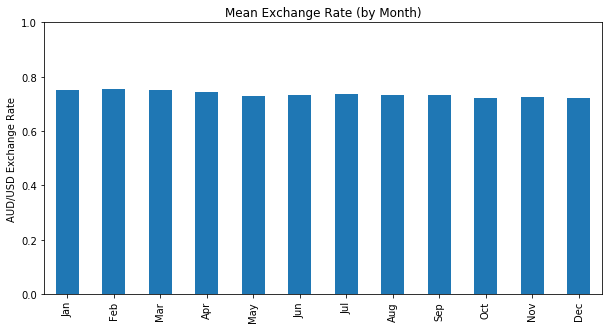

In [22]:
rate_2017_2019 = data[['USD']]['2017':'2019']

mean_exchange_rate(rate_2017_2019)

#### Inspecting stationarity of Time-Series visually

**1. Using the entire dataset**

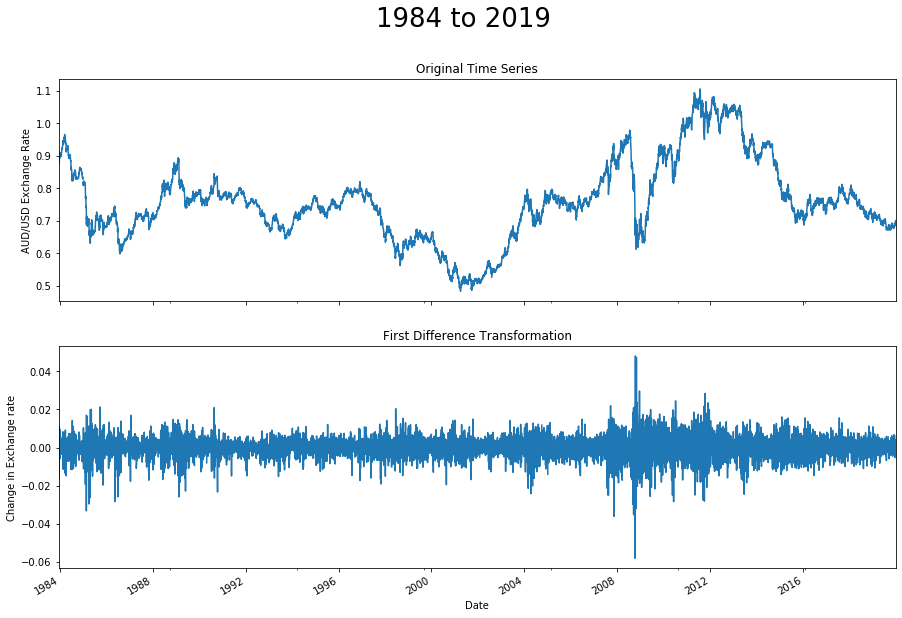

In [23]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(15,10), sharex=True)
fig.suptitle('1984 to 2019', fontsize=26)

rate_1983_2019.plot(ax=ax1, legend=False)
ax1.set_ylabel("AUD/USD Exchange Rate")
ax1.set_title("Original Time Series")

rate_1983_2019.diff().plot(ax=ax2, legend=False)
ax2.set_ylabel("Change in Exchange rate")
ax2.set_title("First Difference Transformation")

plt.show()

**2. In the last 3 years**

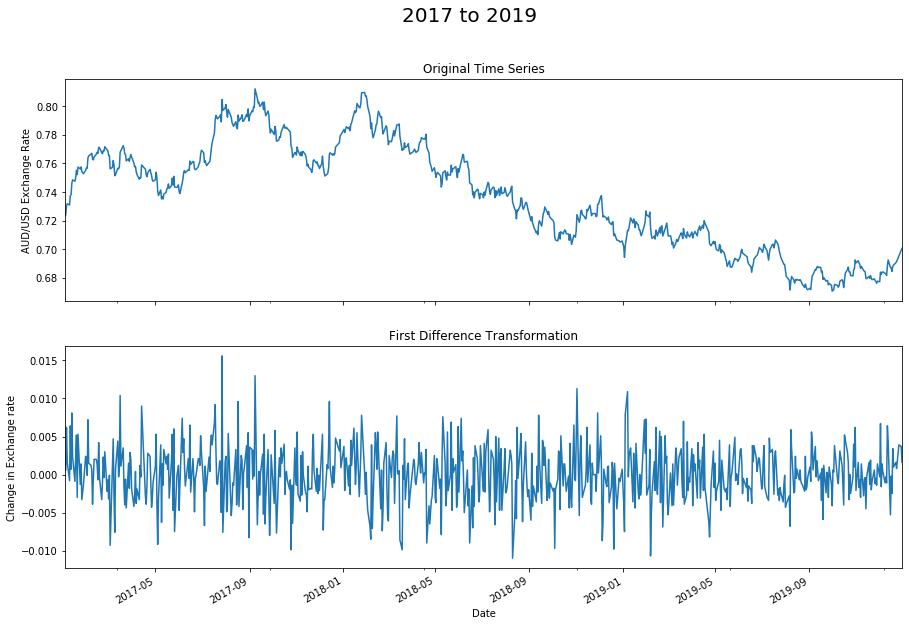

In [24]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(15,10), sharex=True)
fig.suptitle('2017 to 2019', fontsize=20)

rate_2017_2019.plot(ax=ax1, legend=False)
ax1.set_ylabel("AUD/USD Exchange Rate")
ax1.set_title("Original Time Series")

rate_2017_2019.diff().plot(ax=ax2, legend=False)
ax2.set_ylabel("Change in Exchange rate")
ax2.set_title("First Difference Transformation")


plt.show()

**3. In a single year (2018)**

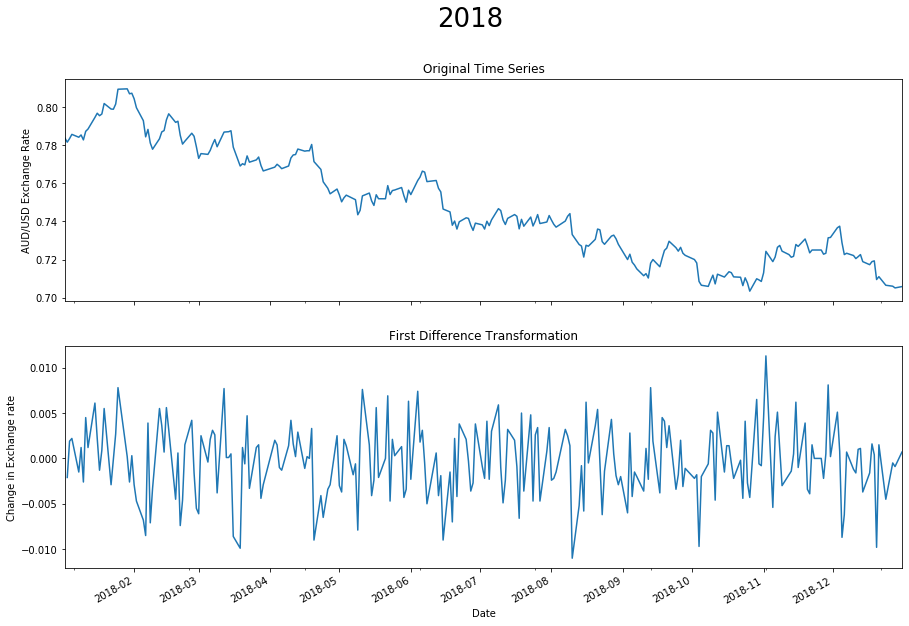

In [25]:
rate_2018 = data[['USD']]['2018']

fig, (ax1,ax2) = plt.subplots(2, figsize=(15,10), sharex=True)
fig.suptitle('2018', fontsize=26)

rate_2018.plot(ax=ax1, legend=False)
ax1.set_ylabel("AUD/USD Exchange Rate")
ax1.set_title("Original Time Series")

rate_2018.diff().plot(ax=ax2, legend=False)
ax2.set_ylabel("Change in Exchange rate")
ax2.set_title("First Difference Transformation")

plt.show()

**4. In each Month of 2018**

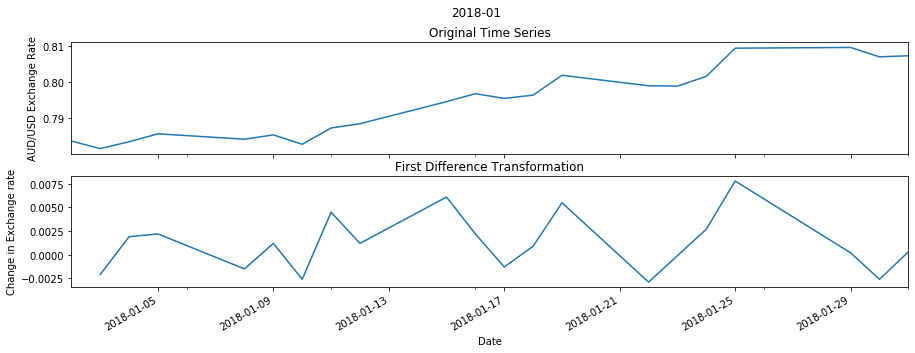

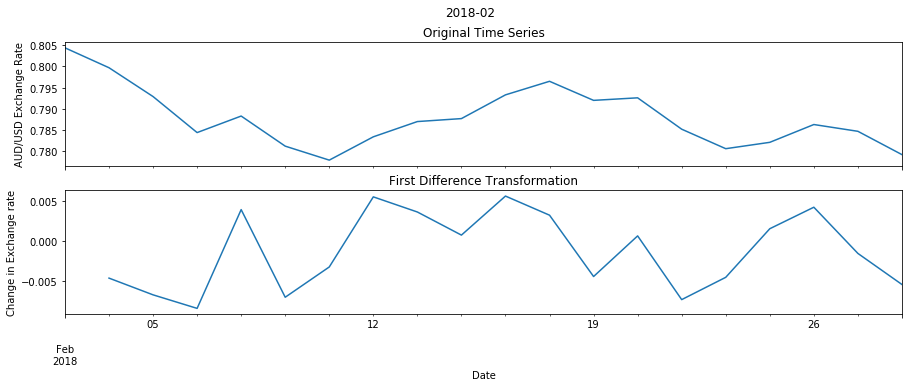

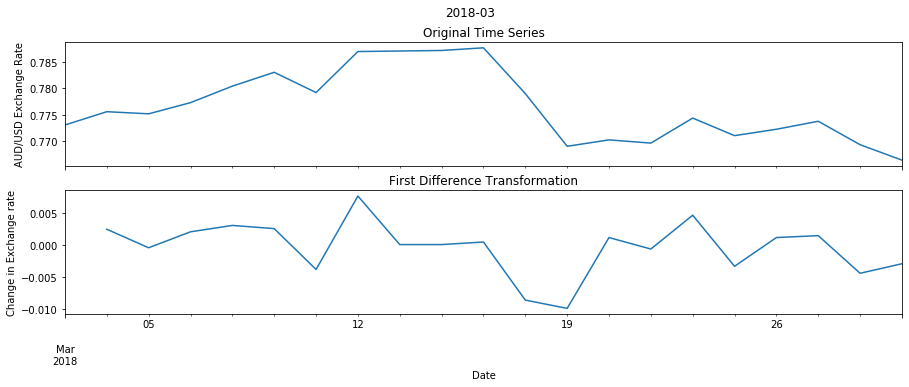

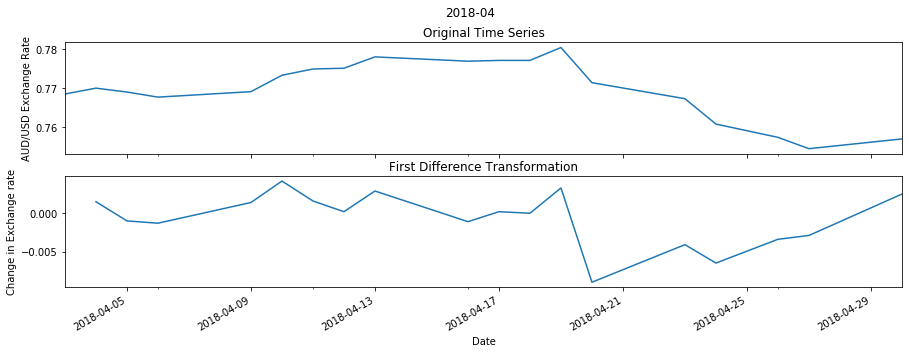

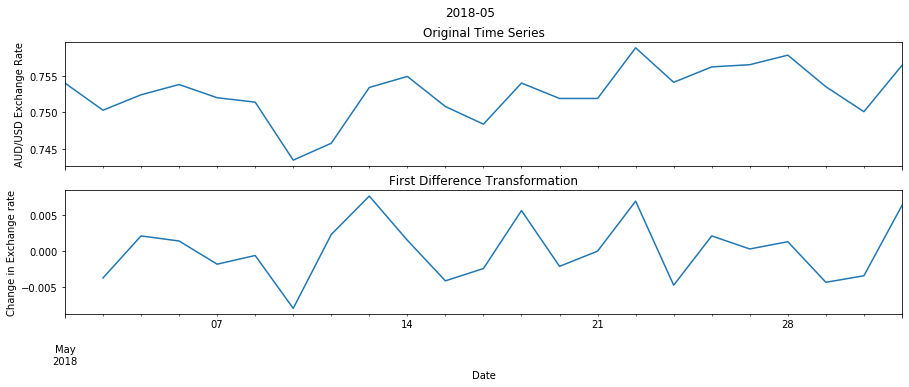

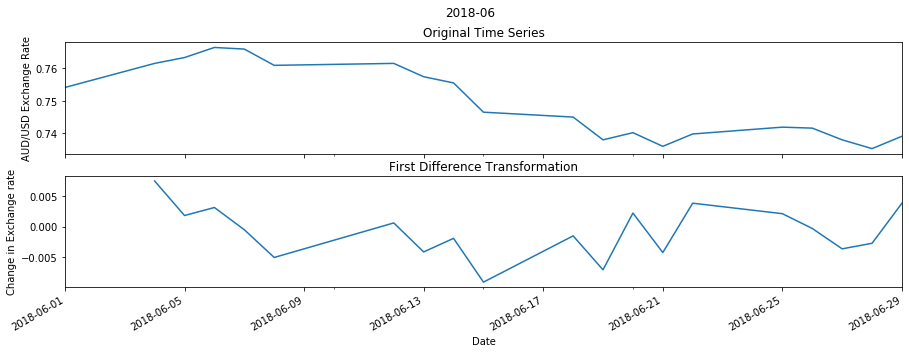

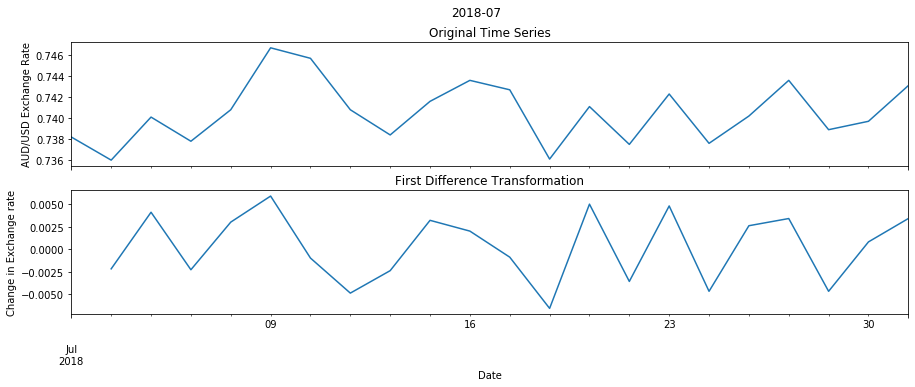

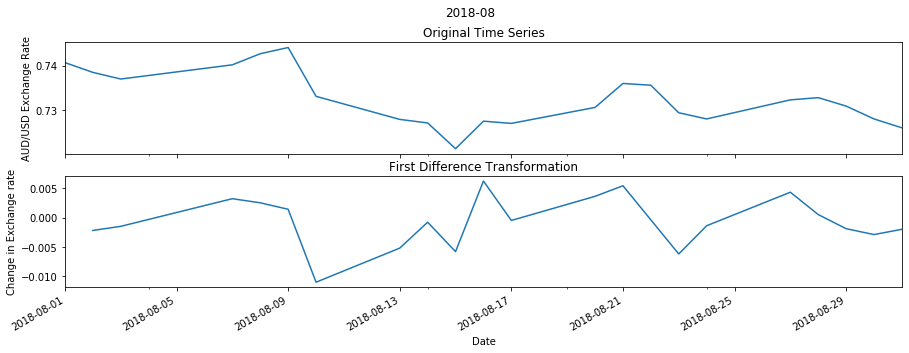

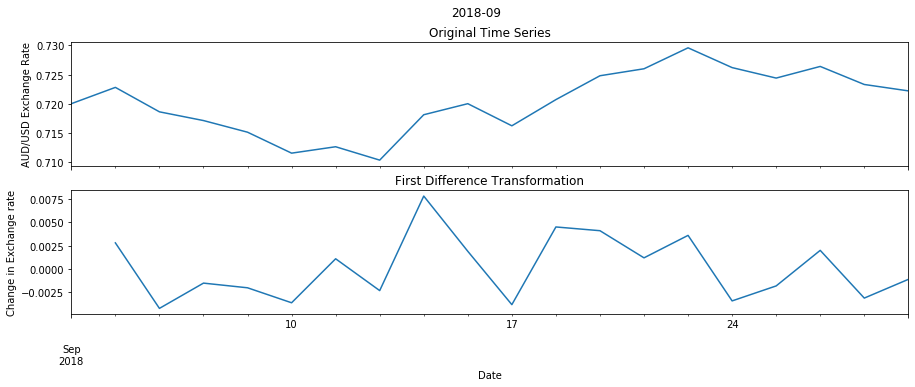

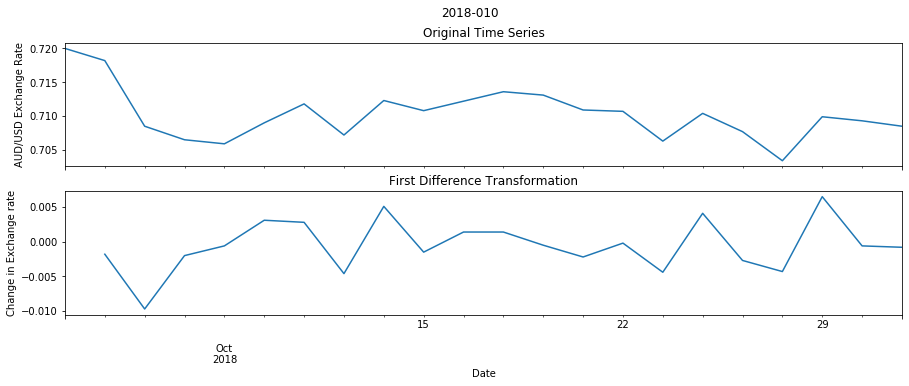

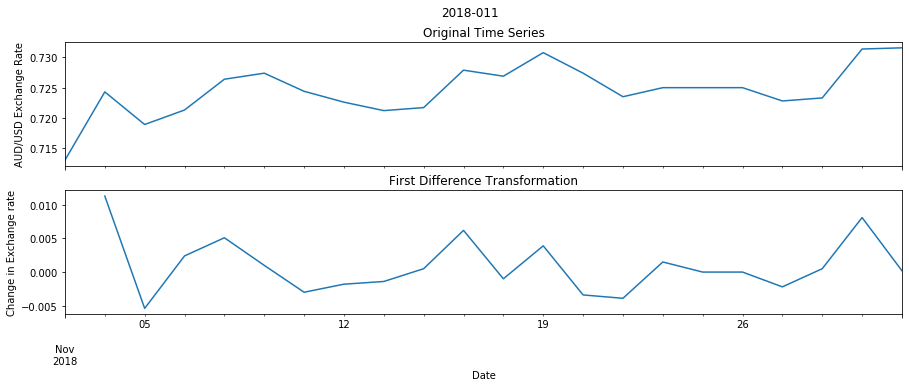

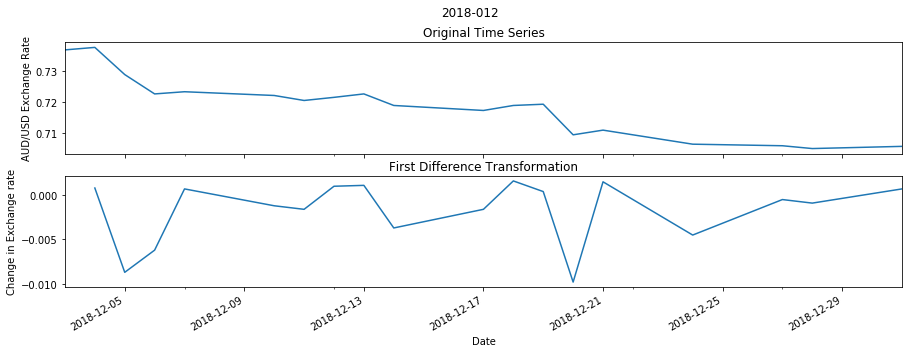

In [26]:
for i in range(1,13):

    rate_2018 = data[['USD']]['2018-{}'.format(i)]

    fig, (ax1,ax2) = plt.subplots(2, figsize=(15,5), sharex=True)
    fig.suptitle('2018-0{}'.format(i))

    rate_2018.plot(ax=ax1, legend=False)
    ax1.set_ylabel("AUD/USD Exchange Rate")
    ax1.set_title("Original Time Series")

    rate_2018.diff().plot(ax=ax2, legend=False)
    ax2.set_ylabel("Change in Exchange rate")
    ax2.set_title("First Difference Transformation")

    plt.show()

#### Inspecting stationarity of Time-Series using Augmented Dicky Fuller Test

https://machinelearningmastery.com/time-series-data-stationary-python/

**Should you make your time series stationary?**

Generally, yes.

Statistical time series methods and even modern machine learning methods will benefit from the clearer signal in the data.

There are many methods to check whether a time series (direct observations, residuals, otherwise) is stationary or non-stationary.

1. **Look at Plots**: You can review a time series plot of your data and visually check if there are any obvious trends or seasonality.
2. **Summary Statistics**: You can review the summary statistics for your data for seasons or random partitions and check for obvious or significant differences.
3. **Statistical Tests**: You can use statistical tests to check if the expectations of stationarity are met or have been violated.

_____________________________________________________________________________________________________________

##### Augmented Dicky Fuller Test
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

**1. ADFuller Test on the entire data**

In [27]:
from statsmodels.tsa.stattools import adfuller

X = rate_1983_2019.fillna(method="ffill").values.flatten()

result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.293064
p-value: 0.174215
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Running the example prints the test statistic value of -2.3. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -2.29 is not less than the value of -2.86 at 5%.

This suggests that we cannot reject the null hypothesis with a significance level of less than 5% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has a unit root, and in turn that **our time series is not stationary** or has a time-dependent structure.

**2. ADFuller Test for last 3 years**

In [28]:
X = rate_2017_2019.fillna(method="ffill").values.flatten()

result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.220262
p-value: 0.664819
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


**3. ADFuller Test for 2018**

In [29]:
X = rate_2018.fillna(method="ffill").values.flatten()

result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.449761
p-value: 0.558202
Critical Values:
	1%: -3.859
	5%: -3.042
	10%: -2.661


**4. ADFuller Test for all months of 2018**

In [30]:
def monthwise_adf(year_='2018'):
    
    month_names = ["Jan", 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    adfuller_df = pd.DataFrame(index=month_names, columns=['ADF Statistic',
                                                          'p-value',
                                                          '1%', '5%', '10%'])

    for i in range(0,12):

        X = data[['USD']]['{}-{}'.format(year_, i+1)].fillna(method='ffill').dropna().values.flatten()

        result = adfuller(X)

        res = {}
        res['ADF Statistic'] = result[0]
        res['p-value'] = result[1]
        for key, value in result[4].items():
            res[key] = value

        adfuller_df.iloc[i,:] = res
    
    adfuller_df = adfuller_df.sort_values(by='p-value')
    
    return adfuller_df

In [31]:
def count_stationary_months(start_year=2000, end_year=2019):

    month_names = ["Jan", 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    stationary_months_count = {}

    for month in month_names:
        stationary_months_count[month] = 0

    for year in np.arange(start_year, end_year):

        adf = monthwise_adf(year)
        stationary_months = adf[adf['p-value'] <= 0.05]
        stationary_months.index
        for month in stationary_months.index:
            stationary_months_count[month] += 1
            
    return stationary_months_count

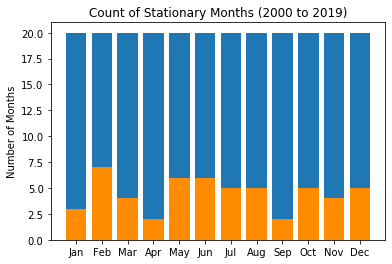

In [39]:
stationary_month_count = count_stationary_months()
months = stationary_month_count.keys()
counts = stationary_month_count.values()

total_months_2000_2019 = np.ones((12, 1)) * 20 
plt.bar(months, total_months_2000_2019.flatten())
plt.bar(months, counts, color='darkorange')
plt.title("Count of Stationary Months (2000 to 2019)")
plt.ylabel("Number of Months")
plt.show()

#### Is the first difference/change percentage of our time series stationary?

ADF Statistic: -22.922524
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


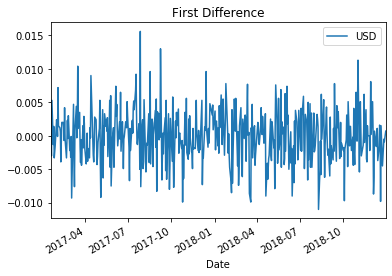

In [33]:
first_diff = train_rate.diff().dropna()
X = first_diff.values.flatten()

result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
first_diff.plot(title='First Difference')
plt.show()

The first difference transformation has given us a stationary time series with a p-value of 0! This is amazing! But let's still check other transformations so that we know that we've covered all possible alternatives.

For this we will create a function that applies all of the below transformations. It will also store the p-value, ADF Statistic and the different ADF statistic thresholds from all the tranformations after applying the *Augmented Dicky-Fuller Test*.

**1. ADFuller with Log Transform**\
**2. ADFuller with Square Root Transform**\
**3. ADFuller with Proportional Change Transformation**\
**4. ADFuller with Log Returns**

In [34]:
def adfuller_on_transformations(data):
    
    first_diff = data.diff().dropna()
    log_transform = np.log(data).fillna(method='ffill')
    sqrt_transform = np.sqrt(data).fillna(method='ffill')
    propn_change_transform = (data.shift() / data).dropna()
    log_returns = np.log(data / data.shift()).dropna()

    transforms = [first_diff, log_transform, sqrt_transform, propn_change_transform, log_returns]
    transform_labels = ['First Difference', 'Log', 'Square Root', 'Proportional Change', 'Log Returns']

    adfuller_transforms = pd.DataFrame(index=transform_labels, columns=['ADF Statistic',
                                                                        'p-value',
                                                                        '1%',
                                                                        '5%',
                                                                        '10%'])
    
    fig, ax = plt.subplots(len(transform_labels)+1, figsize=(20,20), sharex=True)
    
    data.plot(ax=ax[0])
    ax[0].set_title("Data before Transformation", fontsize=16)

    for i, (transform, name) in enumerate(zip(transforms, transform_labels)):
            
            transform.plot(ax=ax[i+1], legend=False)
            ax[i+1].set_title(name + " Transform", fontsize=16)
            
            X = transform.values.flatten()

            result = adfuller(X)
            
            res = {}
            res['ADF Statistic'] = result[0]
            res['p-value'] = result[1]
            
            for key, value in result[4].items():
                res[key] = value

            adfuller_transforms.at[name,:] = res

    adfuller_transforms = adfuller_transforms.sort_values(by='ADF Statistic')

    return adfuller_transforms

#### Transform entire dataset for the AUD/USD currency pair


,ADF Statistic,p-value,1%,5%,10%
First Difference,-47.4837,0,-3.43107,-2.86186,-2.56694
Log Returns,-15.2532,4.97687e-28,-3.43107,-2.86186,-2.56694
Proportional Change,-15.1818,6.18255e-28,-3.43107,-2.86186,-2.56694
Square Root,-2.4884,0.118322,-3.43107,-2.86186,-2.56694
Log,-2.47772,0.120991,-3.43107,-2.86186,-2.56694


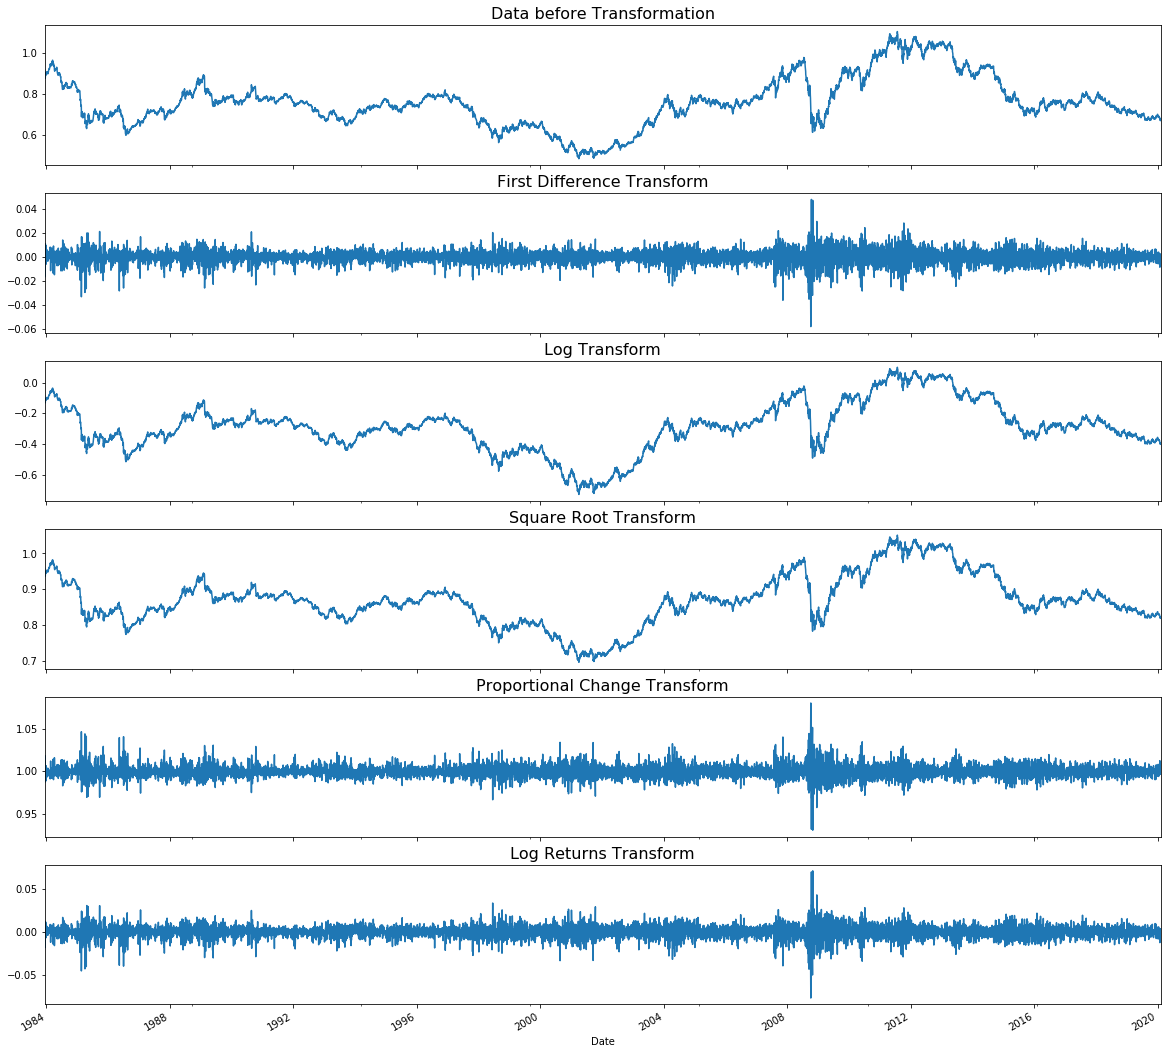

In [35]:
adfuller_on_transformations(data['USD'])

#### Apply transformations on training data

,ADF Statistic,p-value,1%,5%,10%
First Difference,-22.9225,0,-3.44379,-2.86747,-2.56993
Log Returns,-22.9002,0,-3.44379,-2.86747,-2.56993
Proportional Change,-22.8889,0,-3.44379,-2.86747,-2.56993
Square Root,-1.08471,0.721131,-3.44377,-2.86746,-2.56992
Log,-1.06267,0.729726,-3.44377,-2.86746,-2.56992


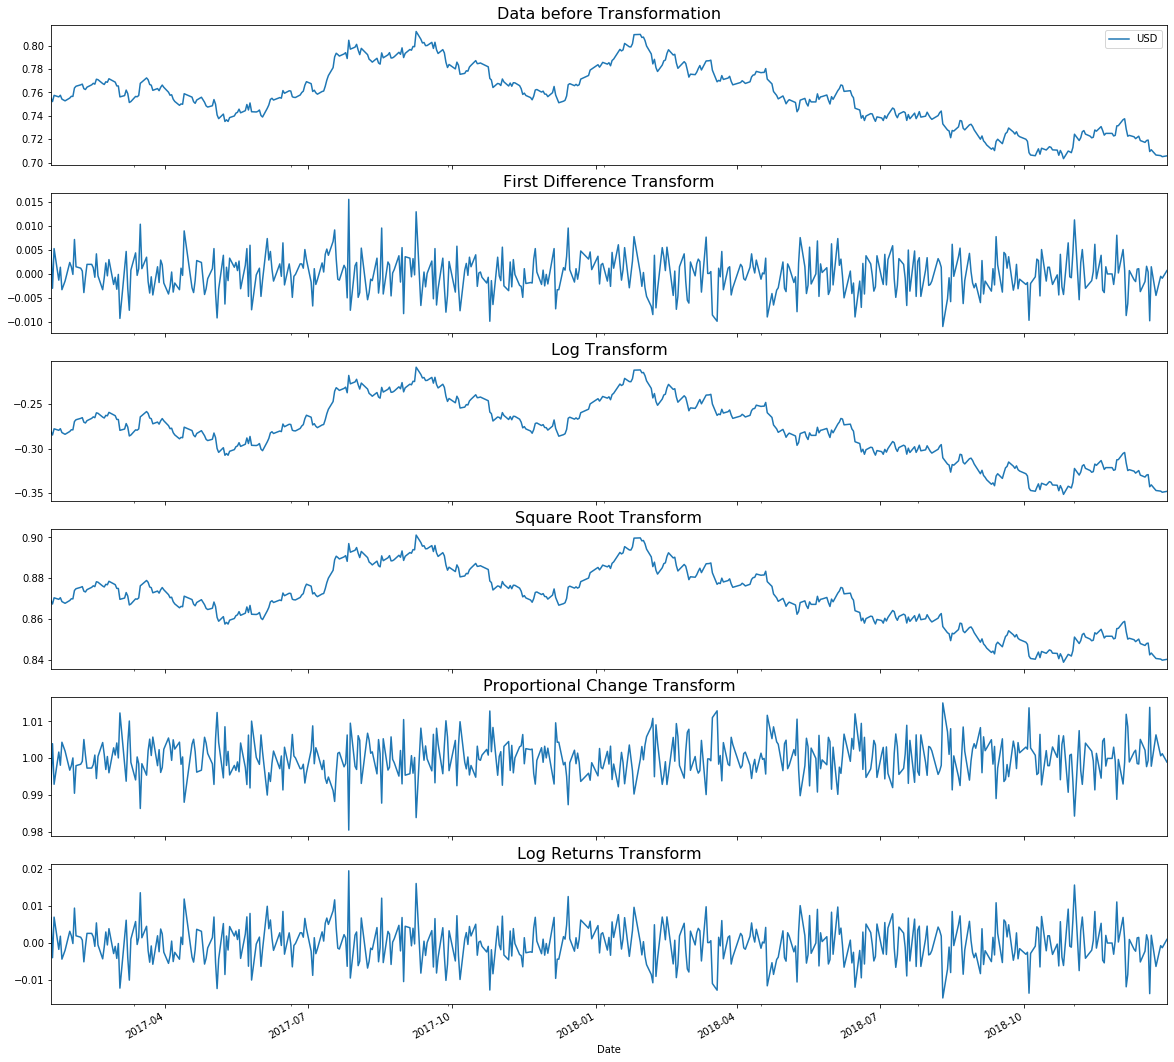

In [36]:
adfuller_on_transformations(train_rate)

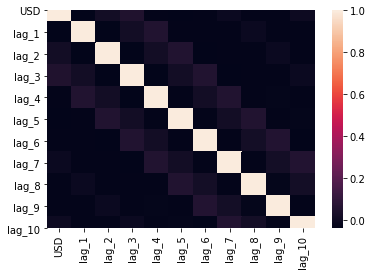

In [37]:
sns.heatmap(train_df.diff().corr())

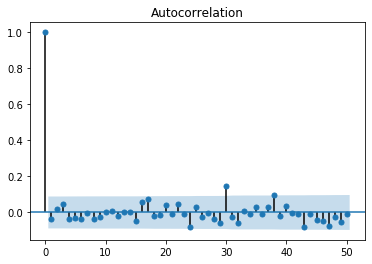

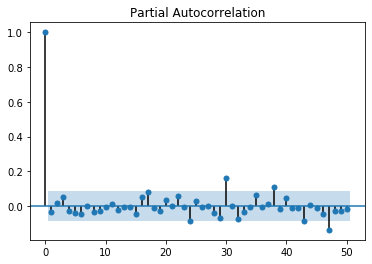

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

first_diff = train_rate.diff().dropna()

_ = plot_acf(first_diff, lags=50)

_ = plot_pacf(first_diff, lags=50)
